#### GUFI Notebook 3

- Process science frames (using biases/flats)


In [167]:
# load up modules (keep adding to these as we go along)

import sys
import os
import numpy as np
from astropy.io import fits
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib.colors import LogNorm
from astropy.visualization import astropy_mpl_style
plt.style.use(astropy_mpl_style)

from astropy.utils.data import get_pkg_data_filename
from astropy.io import fits
from astropy.io import fits as pyfits

from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from photutils import aperture_photometry, CircularAperture
from astropy.stats import mad_std
from photutils import DAOStarFinder

In [168]:
def stack_images(filepath,biaspath): # from notebook 2
    bias_data = fits.getdata(get_pkg_data_filename(biaspath),ext=0)
    image_stack_raw = fits.getdata(get_pkg_data_filename(filepath),ext=0)
    image_stack_biased =image_stack_raw - bias_data
    return(image_stack_biased)

Moved the LP349 fits files  into the `/science/LP349` folder

In [169]:
bias_dir = os.getcwd() + '/bias/'
flat_dir = os.getcwd() + '/flat/'
science_dir = os.getcwd() + '/science/LP345/'
bias_file = 'masterbias_11.fits'
biaspath = bias_dir + bias_file

Decided to work with `Flat__006` as it appears to be more 'even' despite lower counts

In [170]:
# Flat_I__006.fits
flatpath = flat_dir + 'Flat_I__006.fits'
this_flat_stack = stack_images(flatpath,biaspath)
master_flat06 = np.average(this_flat_stack, axis=0)
normalized_master_flat06 = master_flat06/np.mean(master_flat06)

In [171]:
!ls science/LP345

LP349__001.fits  LP349__002.fits  LP349__003.fits  LP349__004.fits


In [172]:
science_list = os.listdir(science_dir)

In [173]:
for science in science_list:
    this_science = science_dir + science
    hdul = fits.open(this_science)
    print (science + '\t' + 'First frame: ' + hdul[0].header['FRAME'] + '\t' + 'Exposure (sec):' + str(hdul[0].header['EXPOSURE']) + '\t' + 'Number of integrations:' + str(hdul[0].header['NUMKIN']))     

LP349__003.fits	First frame: 2017-12-21T04:23:40.000	Exposure (sec):5.0	Number of integrations:600
LP349__002.fits	First frame: 2017-12-21T03:33:31.000	Exposure (sec):5.0	Number of integrations:600
LP349__001.fits	First frame: 2017-12-21T02:43:22.000	Exposure (sec):5.0	Number of integrations:600
LP349__004.fits	First frame: 2017-12-21T05:13:45.000	Exposure (sec):5.0	Number of integrations:600


Let's get an average of the science image stack, remove the bias and visualise it

In each case let's dump the resulting image as a FITS file so we can more dynamically study it using DS9

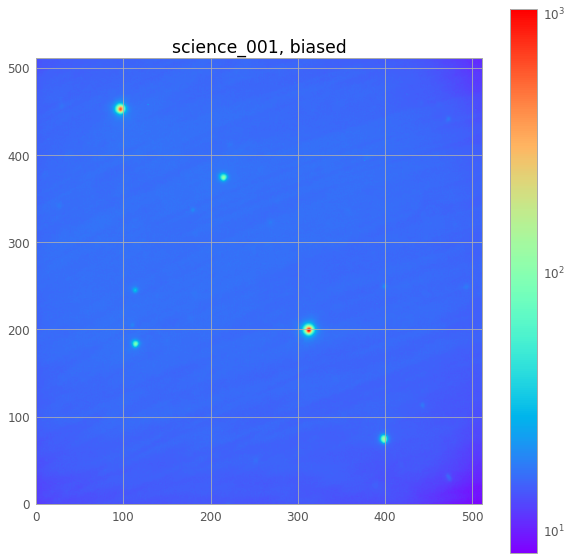

In [174]:
# get LP349__001.fits - bias
sciencepath = science_dir + 'LP349__001.fits'
this_science_stack = stack_images(sciencepath,biaspath)
science_001 = np.average(this_science_stack, axis=0)

plt.figure(figsize=(10,10))
plt.imshow(science_001, origin='lower', cmap='rainbow', norm=LogNorm())  # use LogNorm to bring out structure
plt.title('science_001, biased')
plt.colorbar();

outfile = 'stacked_001_bias.fits'
hdu = fits.PrimaryHDU(science_001)
hdu.writeto(outfile, overwrite=True)

Fringing is apparent - as are the effects of the flat field (notably at the edges)

Let's get an average of the science image stack again, remove the bias and then flatfield it

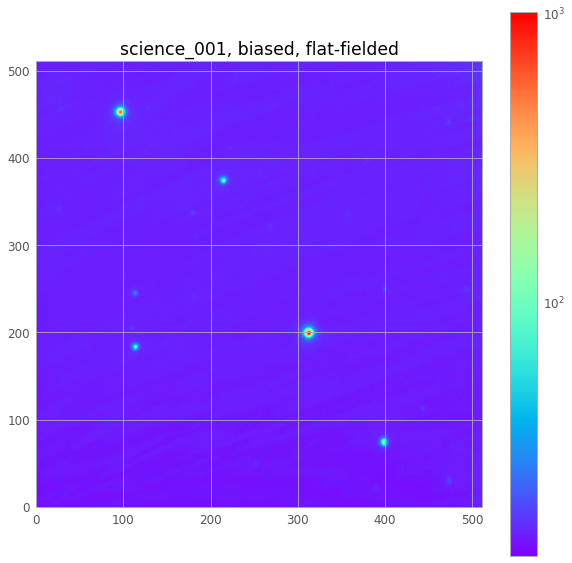

In [175]:
# get LP349__001.fits - bias + flat
sciencepath = science_dir + 'LP349__001.fits'
this_science_stack = stack_images(sciencepath,biaspath)

this_science_stack = stack_images(sciencepath,biaspath)/normalized_master_flat06  # use numpy vectorisation

science_001 = np.average(this_science_stack, axis=0)

plt.figure(figsize=(10,10))
plt.imshow(science_001, origin='lower', cmap='rainbow', norm=LogNorm())
plt.title('science_001, biased, flat-fielded')
plt.colorbar();

outfile = 'stacked_001_bias_flat.fits'
hdu = fits.PrimaryHDU(science_001)
hdu.writeto(outfile, overwrite=True)

Looks very even, seems like the flat fielding has done a good job

Let's repeat this process except here sum up all the frames into one deep exposure

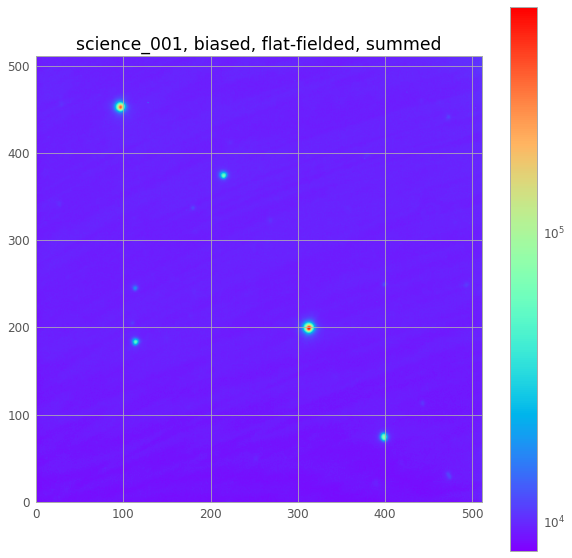

In [176]:
# get LP349__001.fits - bias + flat - summed
sciencepath = science_dir + 'LP349__001.fits'
this_science_stack = stack_images(sciencepath,biaspath)

this_science_stack = stack_images(sciencepath,biaspath)/normalized_master_flat06  # use numpy vectorisation

science_001 = np.sum(this_science_stack, axis=0)

plt.figure(figsize=(10,10))
plt.imshow(science_001, origin='lower', cmap='rainbow', norm=LogNorm())
plt.title('science_001, biased, flat-fielded, summed')
plt.colorbar();

outfile = 'stacked_001_bias_flat_sum.fits'
hdu = fits.PrimaryHDU(science_001)
hdu.writeto(outfile, overwrite=True)

From the DS9 viewer, the fringing is pretty extreme, with variations from 8700 - 9700 in terms of background counts.

Use DAOFIND to identify sources in the field

In [177]:
fwhm = 10.0         #  in pixels
source_snr = 25     #  Signal to noise ratio
bkg_sigma = mad_std(science_001)    # estimate of the variation in the background
daofind = DAOStarFinder(fwhm=fwhm, threshold=source_snr*bkg_sigma)    # set up method to find sources using DAOStarFinder
sources = daofind(science_001)   # find sources

In [178]:
sources

id,xcentroid,ycentroid,sharpness,roundness1,roundness2,npix,sky,peak,flux,mag
int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64
1,4.755437678228143,4.696793133588684,0.29417844819848227,-0.10233029801697982,0.005190107847953035,169,0.0,8527.2548828125,3.081601082131072,-1.2219410448768973
2,506.6613492121204,4.686694900710474,0.26289920297100483,0.177397458993037,0.04996250488369399,169,0.0,9284.4150390625,3.5787887345542524,-1.3843401539622857
3,472.31770827441085,30.02365812826551,0.5675760650137474,-0.4393942051144382,0.3953780022806897,169,0.0,11732.91015625,1.063380155986462,-0.0667213789288708
4,398.05117457663806,73.98198815703127,0.6830824578481858,-0.00625151739776425,0.20167917689165682,169,0.0,79879.1640625,27.01868184768139,-3.579160393520875
5,113.58938721682752,183.02069386586805,0.843600468551868,0.034580974812407315,0.017778564936444013,169,0.0,55021.5625,14.929810685087324,-2.935135751907474
6,312.1130791137971,198.90274303278974,0.8208882450262474,0.05866410162718021,0.05005622243760235,169,0.0,607146.0,200.37507684754047,-5.754609254805459
7,113.07575042899289,244.65217556337475,0.7713181987821641,-0.007159171342658221,0.04851594635383667,169,0.0,17687.796875,2.91176684940681,-1.1603914931634143
8,214.33724185179048,373.66281618459607,0.7410440494928157,-0.03060600108118234,0.009480761694050998,169,0.0,62068.65234375,18.94164087089245,-3.1935439955787555
9,96.2881619740618,451.95041833476813,0.7945388225362182,0.03306330821961486,0.05068227552266716,169,0.0,368951.46875,123.72048282686828,-5.231104015489093


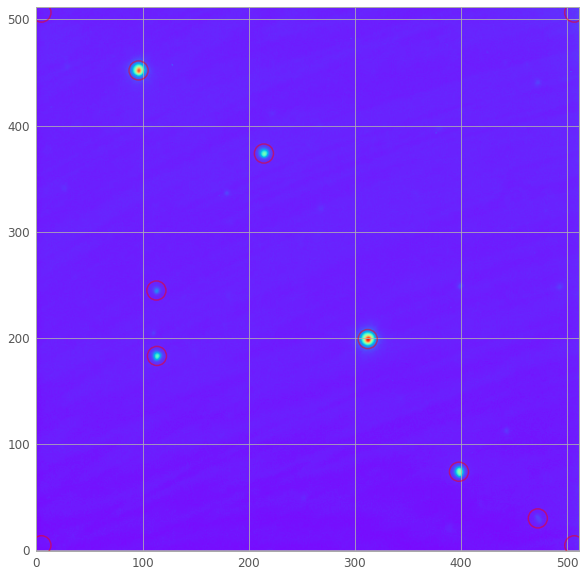

In [179]:
fig=plt.figure(figsize=(10, 10))
positions = list(zip(sources['xcentroid'],sources['ycentroid'])) # positions = (sources['xcentroid'], sources['ycentroid'])    
position_apps = CircularAperture(positions, r=9.)    
plt.imshow(science_001, origin='lower', cmap='rainbow', norm=LogNorm())
position_apps.plot(color='red', lw=1.5, alpha=0.5)

Determine the optimum aperture from the stack

In [180]:
# this code takes an x,y position, and puts apertures of increasing area (radius) around them, estimates the flux.
# plotting the flux against the aperture area can tell you when you move from something interesting 
# (i.e. the growth is non-linear) to something indistinguishable from the background (linear)
# in this regime, its basically all sky, whose flux will grow linearly with aperture area
# this isn't the case as you sample a stellar PSF (e.g. https://arxiv.org/pdf/1907.04421.pdf)

def estimate_aperture(position,imagefile):  # must be as (x,y)

   x = []
   y = []
   for i in range(1,10):
       aperture_radius = i
       apertures = CircularAperture(position, r=aperture_radius)   
       phot_table = aperture_photometry(imagefile, apertures)
       print("Radius: {:2d} Area: {:4.1f} Flux: {:12.1f}".format(i,3.1415926*(i**2),phot_table['aperture_sum'][0]))
       x.append(3.1415926*(i**2))
       y.append(phot_table['aperture_sum'][0])
        
   yN = np.array(y[-3:])
   xN = np.array(x[-3:])
   m, c = np.polyfit(xN, yN, 1)  #  finds m & c out of y = mx + c

   plt.figure()
   plt.plot(x,y)
   plt.plot(x, m*np.array(x) + c)
   cnt = 1
   for locx in x:
      plt.text(locx, y[-1], str(cnt), fontsize = 12)
      cnt = cnt + 1
   plt.plot(x, y, 'o', color='black')
   plt.xlabel('Aperture area')
   plt.ylabel('Flux')
   plt.title('Aperture flux as a function of increasing area');        

Let's apply the flux/aperture 'test' which plots the flux in a growing aperture around a point source. Initially the flux levels increases rapidly as it's sampling the 'core' of the stellar peak but gradually the background contribution takes over. Where the increase scales linearly is crudely the cut-off between being stellar dominated instead of background dominated and this can be used as an aperture estimate.

We'll try it on the brightest star first

In [181]:
positions[5]  # brightest star

(312.1130791137971, 198.90274303278974)

Radius:  1 Area:  3.1 Flux:    1712345.7
Radius:  2 Area: 12.6 Flux:    5551890.8
Radius:  3 Area: 28.3 Flux:    9323664.7
Radius:  4 Area: 50.3 Flux:   12093766.4
Radius:  5 Area: 78.5 Flux:   13950018.0
Radius:  6 Area: 113.1 Flux:   15239590.2
Radius:  7 Area: 153.9 Flux:   16229373.5
Radius:  8 Area: 201.1 Flux:   17076636.6
Radius:  9 Area: 254.5 Flux:   17867287.1


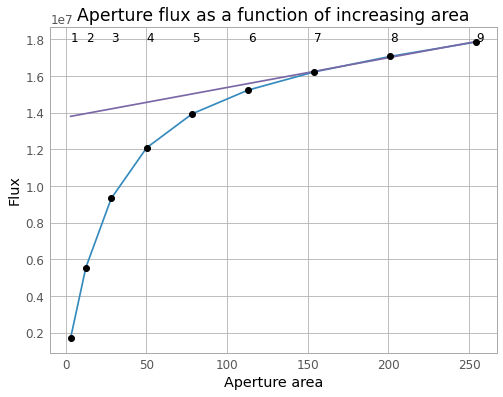

In [182]:
estimate_aperture(positions[5],science_001)

Looks like a radius of 7

Let's try it on the next brightest star

In [183]:
positions[7]  # next brightest star

(214.33724185179048, 373.66281618459607)

Radius:  1 Area:  3.1 Flux:     194354.5
Radius:  2 Area: 12.6 Flux:     646274.8
Radius:  3 Area: 28.3 Flux:    1149747.6
Radius:  4 Area: 50.3 Flux:    1613448.5
Radius:  5 Area: 78.5 Flux:    2045340.2
Radius:  6 Area: 113.1 Flux:    2476441.0
Radius:  7 Area: 153.9 Flux:    2933139.7
Radius:  8 Area: 201.1 Flux:    3430045.5
Radius:  9 Area: 254.5 Flux:    3974848.3


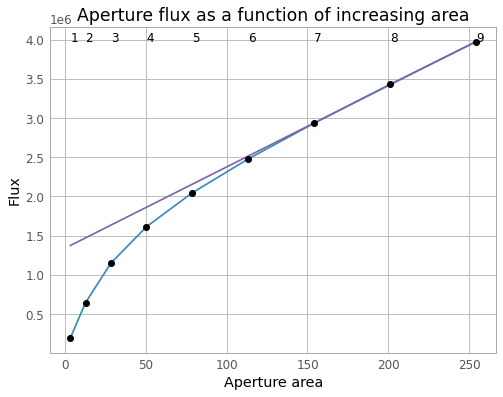

In [184]:
estimate_aperture(positions[7],science_001)

More like 6.5 here...

Next steps would be
 - work through the circular photometry approach using `photutils` for one frame
 - apply it to a stack of frames

Quite a few pipelines don't use `photutils`, they make use of adaptions to `SEXTRACTOR` which uses a neural network based codebase to identify, register and perform photometry on reduced CCD frames. Installing it is a pain, thankfully there are Python modules with it baked in, in particular SEP ((https://sep.readthedocs.io/en/v1.1.x/tutorial.html))

SEP formed the basis for TEA-PHOT, an 'automated' pipeline to perform differential photometry from the SHOC high speed photometer at the 1.9m telescope at the Sutherland Observatory in South Africa - see below. 

In [162]:
from IPython.display import IFrame
IFrame(src='https://www.aanda.org/articles/aa/full_html/2019/09/aa35640-19/aa35640-19.html', width = 1000, height=400)

We're going to try out SEP, by applying the basic tutorial they provide.

In [185]:
import sep

Plot the summed science image

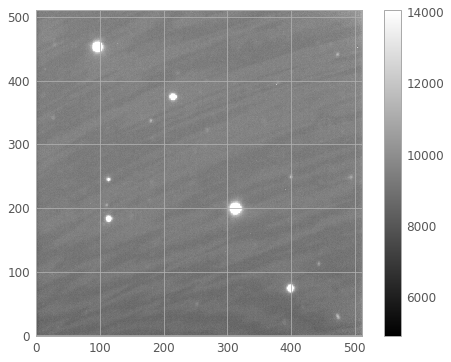

In [186]:
m, s = np.mean(science_001), np.std(science_001)
plt.imshow(science_001, interpolation='nearest', cmap='gray', vmin=m-s, vmax=m+s, origin='lower')
plt.colorbar();

The fringing is really apparent here - on the other hand the flat fielding looks pretty excellent

In [187]:
# measure a spatially varying background on the image
bkg = sep.Background(science_001)

In [188]:
# get a "global" mean and noise of the image background:
print(bkg.globalback)
print(bkg.globalrms)

9423.91015625
152.44778442382812


In [189]:
# evaluate background as 2-d array, same size as original image
bkg_image = bkg.back()
# bkg_image = np.array(bkg) # equivalent to above

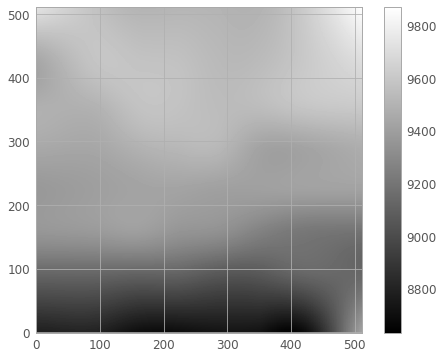

In [190]:
# show the background
plt.imshow(bkg_image, interpolation='nearest', cmap='gray', origin='lower')
plt.colorbar();

The background variations we see here are highly smoothed out - so we're seeing the effect of the fringed put through a filter basically, with whatever subtle flatfield effects there may be left

In [191]:
# evaluate the background noise as 2-d array, same size as original image
bkg_rms = bkg.rms()

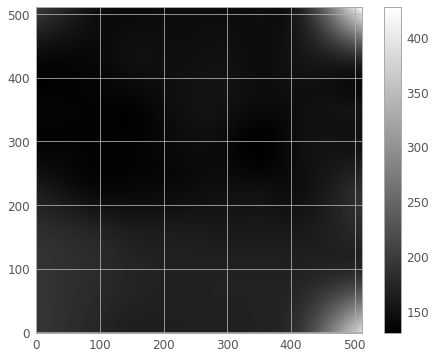

In [192]:
# show the background noise
plt.imshow(bkg_rms, interpolation='nearest', cmap='gray', origin='lower')
plt.colorbar();

Looks like some residual artifacts from the flat fielding left in there - but also because of the vignetting. 

In [193]:
# subtract the background
science_001_sub = science_001 - bkg

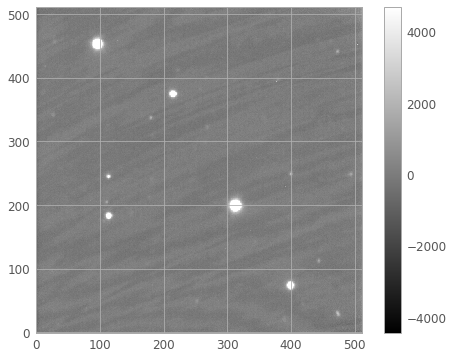

In [194]:
m, s = np.mean(science_001_sub), np.std(science_001_sub)
plt.imshow(science_001_sub, interpolation='nearest', cmap='gray', vmin=m-s, vmax=m+s, origin='lower')
plt.colorbar();

The dominant variations we see here are due to fringing - that's whats giving us the crazy numbers on the legend.

We would need a fringing template to correct for this.

Let's carry on by using `sep` to search for sources with a $\sigma$ = 15 in the field

In [195]:
objects = sep.extract(science_001_sub, 15, err=bkg.globalrms)
len(objects)

6

In [196]:
for i in range(len(objects)):
    print ("Star {:d} [{:f},{:f}]".format(i,objects[i][7],objects[i][8]))
    

Star 0 [398.045640,74.051104]
Star 1 [113.536706,183.072947]
Star 2 [312.043004,199.039134]
Star 3 [113.206803,244.544070]
Star 4 [214.290170,373.795690]
Star 5 [96.220854,452.080263]


Let's overlay the locations of these sources on the summed science frame

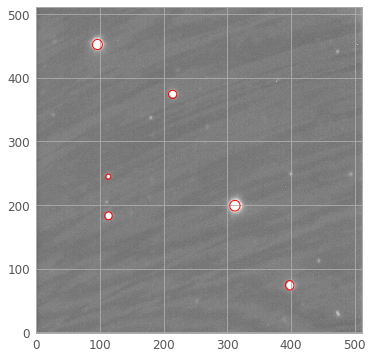

In [197]:
from matplotlib.patches import Ellipse

# plot background-subtracted image
fig, ax = plt.subplots()
m, s = np.mean(science_001_sub), np.std(science_001_sub)
im = ax.imshow(science_001_sub, interpolation='nearest', cmap='gray',
               vmin=m-s, vmax=m+s, origin='lower')

# plot an ellipse for each object
for i in range(len(objects)):
    e = Ellipse(xy=(objects['x'][i], objects['y'][i]),
                width=6*objects['a'][i],
                height=6*objects['b'][i],
                angle=objects['theta'][i] * 180. / np.pi)
    e.set_facecolor('none')
    e.set_edgecolor('red')
    ax.add_artist(e)

So it's possible to read off which source is which from the list above

Let's implement aperture photometry on all the sources in the summed science image, using a radius of 7 (from above)

In [198]:
flux, fluxerr, flag = sep.sum_circle(science_001_sub, objects['x'], objects['y'],7.0, err=bkg.globalrms, gain=1.0)

In [199]:
for i in range(6):
    print("object {:d}: flux = {:f} +/- {:f}".format(i, flux[i], fluxerr[i]))

object 0: flux = 2160371.689414 +/- 2394.924522
object 1: flux = 1114217.461211 +/- 2167.243905
object 2: flux = 14791955.213828 +/- 4285.811079
object 3: flux = 214119.413398 +/- 1946.163396
object 4: flux = 1458254.045352 +/- 2242.934904
object 5: flux = 9117434.661055 +/- 3562.815748


We can get a sense here of the variation on the flux estimates, it's ~ 0.1% level

Let's dump a fits file for this processed science frame and use DS9 to check it out

In [84]:
outfile = 'stacked_001_bias_flat_sum_sep.fits'
hdu = fits.PrimaryHDU(science_001_sub)
hdu.writeto(outfile, overwrite=True)

The fringing is savage... 

Let's convert the fluxes into magnitudes - specifically what we'll do here is find out the upper/lower fluxes using the error estimate, and then calculate the flux ratio from these extremes, and use -2.5 $\times$ log$_{10}\frac{f1}{f2}$ to determine a $\Delta$m.

In [166]:
for i in range(6):
   print ("The delta magnitude for star {:d} is: {:f}".format(i,(np.log(flux[i] + fluxerr[i]) - np.log(flux[i] - fluxerr[i]))))   

The delta magnitude for star 0 is: 0.037913
The delta magnitude for star 1 is: 0.056001
The delta magnitude for star 2 is: 0.012971
The delta magnitude for star 3 is: 0.217567
The delta magnitude for star 4 is: 0.048458
The delta magnitude for star 5 is: 0.016699


Ranges from 0.22 to 0.013, likely where it's located on the field, local fringe effects etc.

I think we could try and repeat this process on the original stack of frames, except skip the search part and simply apply the photometry extraction part.

Let's do this for the first frame of the stack for Star 2

In [200]:
frame = this_science_stack[0]
x_position = np.array(312.043004)
y_position = np.array(199.039134)
bkg = sep.Background(frame)
bkg_image = bkg.back()
bkg_rms = bkg.rms()
frame1 = frame - bkg
flux, fluxerr, flag = sep.sum_circle(frame1, objects['x'], objects['y'],7.0, err=bkg.globalrms, gain=1.0)
print("object {:d}: flux = {:f} +/- {:f}".format(2, flux[2], fluxerr[2]))

object 2: flux = 22978.617855 +/- 154.840399


Ok let's take this code and embed it in a loop that goes over the full stack, and use some list data structures to store stuff as it's determined.

We'll go for Star 2 and Star 5 using the original `objects` data structure we determined from the summed science image earlier. Ideally you'd pick a star with ~ similar brightness to the target or sum a set of fainter reference stars - but this is fine for now.

Star 2 is LP349-25 incidentally.

In [201]:
starflx = []
starerrflx = []
starflx1 = []
starerrflx1 = []

for frame in this_science_stack:
   bkg = sep.Background(frame)
   bkg_image = bkg.back()
   bkg_rms = bkg.rms()
   frame1 = frame - bkg
   flux, fluxerr, flag = sep.sum_circle(frame1, objects['x'], objects['y'],7.0, err=bkg.globalrms, gain=1.0)
   starflx.append(flux[2])
   starerrflx.append(fluxerr[2])
   starflx1.append(flux[5])
   starerrflx1.append(fluxerr[5])

Ok so now we'll plot both time-series

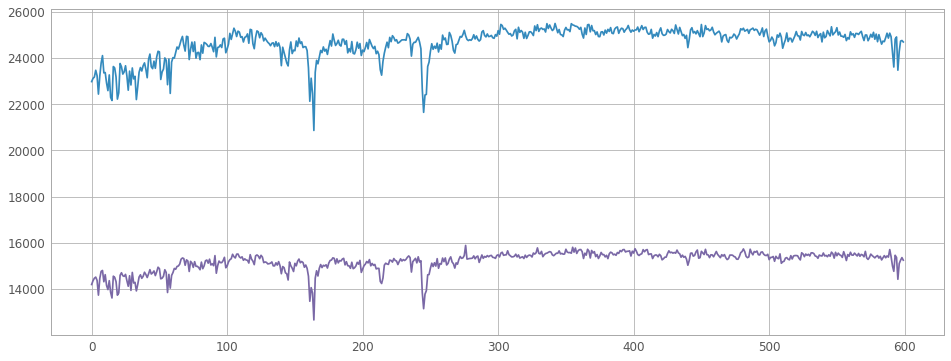

In [135]:
# plot time series
frame_no = range(0,len(starflx))
fig=plt.figure(figsize=(16, 6))
plt.plot(frame_no,starflx);
plt.plot(frame_no,starflx1);
plt.show()

Ok this is pretty excellent - we can see very similar behaviour common to both stars - there looks like a little dink around frame 280 in star 5...

Ok let's try and do some basic differential photometry - we'll create two numpy arrays out of the lists, this allows us to apply vectorisation to the calculation of the differential flux in magnitudes which is based on the flux ratio at each timepoint

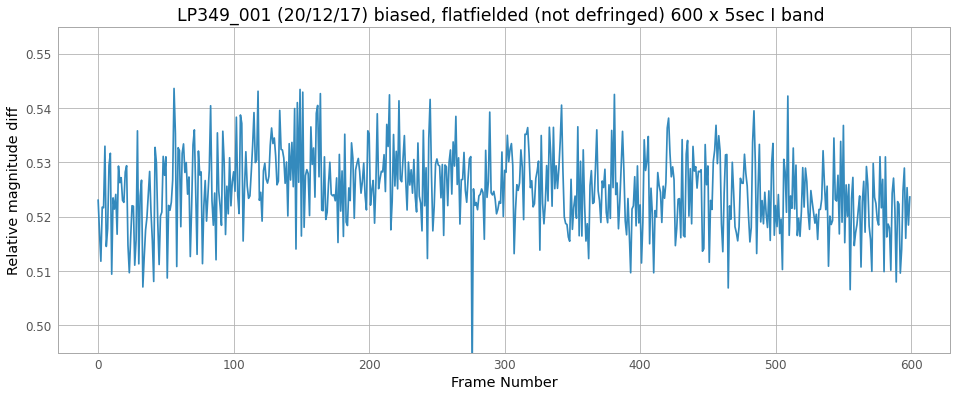

In [203]:
# Let's try and divide it out...
# create two arrays, so apply vectorisation

sflux1 = np.array(starflx)
rflux1 = np.array(starflx1)
dflux = -2.5*np.log10(rflux1/sflux1)
frame_no = range(0,len(starflx))

fig=plt.figure(figsize=(16, 6))
plt.plot(frame_no,dflux);
plt.ylim(np.mean(dflux)-0.03,np.mean(dflux)+0.03);
plt.title('LP349_001 (20/12/17) biased, flatfielded (not defringed) 600 x 5sec I band ')
plt.xlabel('Frame Number')
plt.ylabel('Relative magnitude diff')
plt.show();

In [207]:
print("Mean mag: {:4.3f}, delmag: {:4.3f}".format(np.mean(dflux), np.std(dflux)))

Mean mag: 0.525, delmag: 0.007


The 'dink' we see at ~ 280 is courtesy of the reference star. The magnitude error is in the same ballpark as that in published work from GUFI so that's a good start